In [4]:
[ 5 for i in range(5)]

[5, 5, 5, 5, 5]

In [5]:
units=[5]+[ 6 for i in range(5)]

In [6]:
units

[5, 6, 6, 6, 6, 6]

In [7]:
import numpy as np
theta = np.random.rand(6, 6) * 2 * 0.1

In [8]:
theta

array([[0.02741814, 0.10356672, 0.0445273 , 0.08991502, 0.09260105,
        0.09714825],
       [0.10911038, 0.15391256, 0.04466203, 0.08214517, 0.16280373,
        0.01525387],
       [0.15790373, 0.05097278, 0.07246678, 0.05153621, 0.01626708,
        0.02882469],
       [0.05666661, 0.06132606, 0.14228567, 0.00667101, 0.17282739,
        0.02585841],
       [0.17179965, 0.05147524, 0.02441491, 0.11906685, 0.14898085,
        0.06001863],
       [0.05525843, 0.03410592, 0.0706269 , 0.08917456, 0.10510551,
        0.00022393]])

In [10]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection  import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

D:\soft\Python\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
D:\soft\Python\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
D:\soft\Python\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [11]:
def create_data():
    iris = load_iris()
    df = pd.DataFrame(iris.data, columns=iris.feature_names)
    df['label'] = iris.target
    df.columns = ['sepal length', 'sepal width', 'petal length', 'petal width', 'label']
    data = np.array(df.iloc[:100, [0, 1, -1]])
    for i in range(len(data)):
        if data[i,-1] == 0:
            data[i,-1] = -1
    # print(data)
    return data[:,:2], data[:,-1]

In [13]:
X,y=create_data()
X_train,X_tests,y_train,y_test=train_test_split(X,y,test_size=0.2)

In [14]:
from sklearn.ensemble import AdaBoostClassifier
clf=AdaBoostClassifier(n_estimators=1000,learning_rate=0.5)
clf.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.5,
                   n_estimators=1000, random_state=None)

In [16]:
clf.score(X_tests,y_test)

0.9

In [60]:
class AdaBoost:
    def __init__(self,n_estimators=50,learning_rate=1.0):
        self.clf_num=n_estimators
        self.learning_rate=learning_rate
    def init_args(self,datasets,labels):
        self.X=datasets
        self.Y=labels
        self.M,self.N=datasets.shape
        #弱分类器数目和集合，保存(axis,best_v,final_direct)即划分维度，阙值
        #final_ditect记录是将大于阙值记为1还是-1
        self.clf_sets=[]
        #初始化权重
        self.weights=[1.0/self.M]*self.M
        #G(x)系数
        self.alpha=[]
    def _G(self,features,labels,weights):
        m=len(features)
        error=100000.0
        best_v=0.0
        #某一维特征进行阙值划分
        #learning_rate决定尝试阙值下一次更新的长度
        features_min=min(features)
        features_max=max(features)
        n_step=(features_max-features_min+self.learning_rate)//self.learning_rate
        
        #print('n_step:{}'.format(n_step))
        direct,compare_array=None,None
        #n_step循环次数，将所有的阙值划分err都计算一遍
        for i in range(1,int(n_step)):
            v=features_min+self.learning_rate*i
            if v not in features:
                 #计算误分类个数，用某个维度的阙值对样本进行划分标记
                 #  将 features[k]>v的样本标记为1
                compare_array_positive=np.array(
                [1 if features[k]>v else -1 for k in range(m)])
                weights_error_positive=sum(
                [
                    weights[k] for k in range(m)
                    if compare_array_positive[k]!=labels[k]
                ])
                #  将 features[k]>v的样本标记为-1
                compare_array_nagetive=np.array(
                [-1 if features[k]>v else 1 for k in range(m)])
                
                weights_errors_nagetive=sum(
                    [weights[k] for k in range(m)
                    if compare_array_nagetive[k]!=labels[k]])
                
                if weights_error_positive<weights_errors_nagetive:
                    weight_error=weights_error_positive
                    _compare_array=compare_array_positive
                    direct='positive'
                else:
                    weight_error=weights_errors_nagetive
                    _compare_array=compare_array_nagetive
                    direct='nagetive'
                #print('v:{} error:{}'.format(v, weight_error))
                if weight_error<error:
                    error=weight_error
                    compare_array=_compare_array
                    best_v=v
                    
        return best_v,direct,error,compare_array
    #G（x）系数
    def _alpha(self,error):
        return 0.5*np.log((1-error)/error)
    #规范化因子
    def _Z(self,weights,a,clf):
        return sum([
            weights[i]*np.exp(-1*a*self.Y[i]*clf[i])
            for i in range(self.M)
        ])
    #权值更新
    def _w(self,a,clf,Z):
        for i in range(self.M):
            self.weights[i]=self.weights[i]*np.exp(-1*a*self.Y[i]*clf[i])/Z
    def _f(self,alpha,clf_sets):
        pass
    #根据阙值预测标记
    def G(self,x,v,direct):
        if direct=='positive':
            return 1 if x>v else -1
        else:
            return -1 if x>v else 1
        
    def fit(self,X,y):
        self.init_args(X,y)
        
        for epoch in range(self.clf_num):
            best_clf_error,best_v,clf_result=100000,None,None
            #遍历维度
            for j in range(self.N):
                features=self.X[:,j]
                v,direct,error,compare_array=self._G(features,self.Y,self.weights)
                #寻找最优划分特征的阙值
                if error<best_clf_error:
                    best_clf_error=error
                    best_v=v
                    final_direct=direct
                    clf_result=compare_array
                    #记录当前的维度
                    axis=j
                if best_clf_error==0:
                    break
                    
            #计算G(X)的系数a
            a=self._alpha(best_clf_error)
            self.alpha.append(a)
            #记录弱分类器
            self.clf_sets.append((axis,best_v,final_direct))
            
            Z=self._Z(self.weights,a,clf_result)
            self._w(a,clf_result,Z)
            
    def predict(self,feature):
        #feature是一个样本
        result=0.0
        #遍历所有弱分类器
        for i in range(len(self.clf_sets)):
            axis,clf_v,direct=self.clf_sets[i]
            f_input=feature[axis]
            #累加弱分类器的结果
            result+=self.alpha[i]*self.G(f_input,clf_v,direct)
        return 1 if result>0 else -1
    
    def score(self,X_test,y_test):
        right_count=0
        for i in range(len(X_test)):
            feature=X_test[i]
            if self.predict(feature)==y_test[i]:
                right_count+=1
        return right_count/len(X_test)
    
        

In [57]:
X,y=create_data()
X_train,X_tests,ytrain,y_test=train_test_split(X,y,test_size=0.33)


In [68]:
clf=AdaBoost(n_estimators=10,learning_rate=0.2)
clf.fit(X_train,y_train)
clf.score(X_tests,y_test)

0.7878787878787878

In [64]:
result=[]
for i in range(1,200):
    X,y=create_data()
    X_train,X_tests,y_train,y_test=train_test_split(X,y,test_size=0.33)
    clf=AdaBoost(n_estimators=100,learning_rate=0.2)
    clf.fit(X_train,y_train)
    r=clf.score(X_tests,y_test)
    result.append(r)
print(sum(result))

126.7878787878788


In [18]:
a=1;b=2
a;b

2

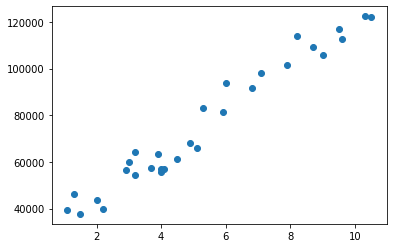

In [21]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
data=np.genfromtxt('data.csv',delimiter=',')
x_data=data[1:,0]
y_data=data[1:,1]
plt.scatter(x_data,y_data)
plt.show()

In [22]:
def compute_loss(b,k,x_data,y_data):
    loss=0
    for i in range(len(x_data)):
        loss+=(y_data[i]-(k*x_data[i]+b))**2
    return loss/float(len(x_data))/2
def gradient_discent(x_data,y_data,lr,epoch,k,b):
    batch=len(x_data)
    for i in range(epoch):
        dz=0
        dk=db=0
        for j in range(batch):
            dz=-(y_data[j]-(k*x_data[j]+b))
            dk+=x_data[j]*dz/float(batch)
            db+=dz/float(batch)
        k-=lr*dk
        b-=lr*db
    return k,b


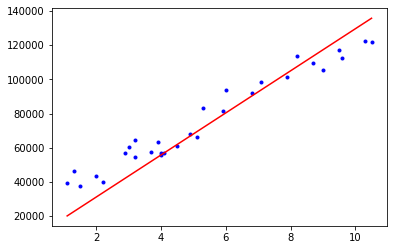

In [23]:
b=k=0
epoch=100
lr=0.01
k,b=gradient_discent(x_data,y_data,lr,epoch,k,b)
plt.plot(x_data,y_data,'b.')
plt.plot(x_data,k*x_data+b,'r')
plt.show()